In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader

from helpers.data_generation.file_management import read_hdf5
from helpers.data_generation.error_generation_ki2 import Residual, CombineDataset
from helpers.model.helpers_model import NeuralNet

import warnings
warnings.filterwarnings('ignore') 
from sklearn.metrics import precision_recall_curve, f1_score, auc, accuracy_score, roc_curve, roc_auc_score

In [2]:
# Build the four classes 
ratio = 0.75
percent = np.array([0.005, 0.015, 0.005])
size = 600

res = Residual()
res.build(size, ratio = ratio, per_error = percent)

print('Data Generation Finished')

Data Generation Finished


In [3]:
ratio = 0.75
percent = np.array([0.005, 0.015, 0.005])
size = 6000
str_ID =  "S"+str(size)+"R"+str(int(ratio*100))
[final_array, metadata] = read_hdf5(str_ID)
metadata ['ID'] = np.arange(0,final_array.shape[0])

data_set = CombineDataset(metadata,'ID','class',final_array)

print('Reading Data Finished')
data_train, data_test = train_test_split(data_set,train_size=0.9,random_state=42)

batch_size = 50
max_epoch = 50


loader_train = DataLoader(data_train, batch_size = batch_size, shuffle = True, 
                          num_workers = 0, drop_last=True)

loader_test = DataLoader(data_test, batch_size = batch_size, shuffle = True, 
                         num_workers = 0, drop_last=True)

Reading Data Finished


In [8]:
metric = 'exactmatch'
netacc = NeuralNet('BasicCNN', 'SGD/momentum')
for epoch in range(max_epoch):
    netacc.train(loader_train)
    res = netacc.test(loader_test, metric = metric)
    
print('Finished Training')
epoch = netacc.load_checkpoint('_optimal')

with torch.no_grad():
    predictions = []
    targets = []
    for data in loader_test:
        images, meta, labels = data
        outputs = netacc.net(images)

        predictions.extend(outputs.cpu().numpy())
        targets.extend(labels.cpu().numpy())
        result = netacc.calculate_metrics(np.round(np.array(predictions)), np.array(targets))
    predictions =np.array(predictions); targets = np.array(targets)

epoch: 1.000, exactmatch: 0.325
epoch: 2.000, exactmatch: 0.345
epoch: 3.000, exactmatch: 0.398
epoch: 4.000, exactmatch: 0.428
epoch: 5.000, exactmatch: 0.450
epoch: 6.000, exactmatch: 0.457
epoch: 7.000, exactmatch: 0.523
epoch: 8.000, exactmatch: 0.602
epoch: 9.000, exactmatch: 0.633
epoch: 10.000, exactmatch: 0.692
epoch: 11.000, exactmatch: 0.707
epoch: 12.000, exactmatch: 0.723
epoch: 13.000, exactmatch: 0.743
epoch: 14.000, exactmatch: 0.748
epoch: 16.000, exactmatch: 0.752
epoch: 17.000, exactmatch: 0.767
epoch: 19.000, exactmatch: 0.770
epoch: 20.000, exactmatch: 0.798
epoch: 24.000, exactmatch: 0.813
epoch: 26.000, exactmatch: 0.820
epoch: 27.000, exactmatch: 0.827
epoch: 33.000, exactmatch: 0.835
Finished Training


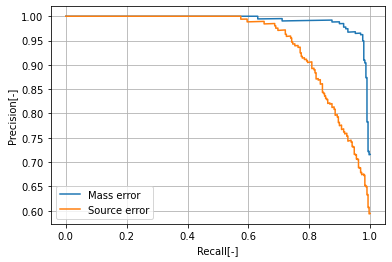

In [9]:
# calculate precision-recall curve
precision0, recall0, thresholds0 = precision_recall_curve(targets[:,0], predictions[:,0])
precision1, recall1, thresholds1 = precision_recall_curve(targets[:,1], predictions[:,1])

plt.plot(recall0, precision0, label='Mass error')
plt.plot(recall1, precision1, label='Source error')
# axis labels
plt.xlabel('Recall[-]')
plt.ylabel('Precision[-]')
# show the legend
plt.legend()
# show the plot

plt.savefig('figures/metric/'+metric+'RecallPrecisionfinal.jpeg')
plt.grid()
plt.show()

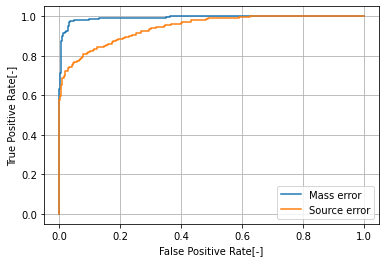

AUC score: 0.912, with exactmatch metric


In [10]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(targets[:,0], predictions[:,0])
lr_fpr, lr_tpr, _ = roc_curve(targets[:,1], predictions[:,1])
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, label='Mass error')
plt.plot(lr_fpr, lr_tpr, label='Source error')
# axis labels
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
# show the legend
plt.legend()
plt.grid()
# show the plot
plt.savefig('figures/metric/'+metric+'ROCfinal.jpeg')
plt.show()

txt = "AUC score: {:.3f}, with "+metric+" metric" 
print(txt.format(result['auc']))

Reading data Finished
epoch: 1.000, auc: 0.603
epoch: 2.000, auc: 0.626
epoch: 4.000, auc: 0.678
epoch: 5.000, auc: 0.690
epoch: 6.000, auc: 0.746
epoch: 7.000, auc: 0.762
epoch: 9.000, auc: 0.806
epoch: 10.000, auc: 0.831
epoch: 11.000, auc: 0.846
epoch: 12.000, auc: 0.854
epoch: 14.000, auc: 0.884
epoch: 15.000, auc: 0.895
epoch: 16.000, auc: 0.902
epoch: 17.000, auc: 0.908
epoch: 18.000, auc: 0.911
epoch: 19.000, auc: 0.911


KeyboardInterrupt: 

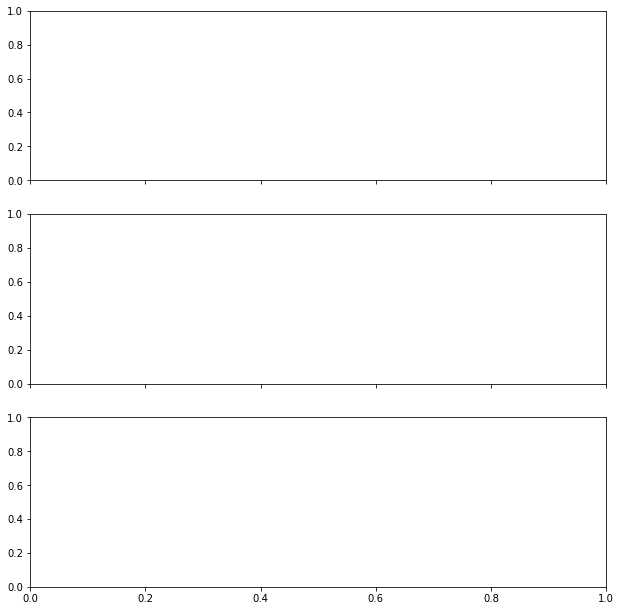

In [11]:
f, axes = plt.subplots(3, figsize=(10, 10), sharex='all', sharey='all',
                       gridspec_kw=dict(left=0.1, right=0.9,bottom=0.1, top=0.9))

percent = np.array([[0.0074, 0.015, 0.0025], [0.005, 0.0142, 0.005], [0.005, 0.0142, 0.0049]])
size = 6000; ratio = 0.75;

for ii in range(3):

    res = Residual()
    res.build(size, ratio = ratio, per_error = percent[ii,:])

    str_ID =  "S"+str(size)+"R"+str(int(ratio*100))
    [final_array, metadata] = read_hdf5(str_ID)

    print('Reading data Finished')
    
    str_ID =  "S"+str(size)+"R"+str(int(ratio*100))
    [final_array, metadata] = read_hdf5(str_ID)
    metadata ['ID'] = np.arange(0,final_array.shape[0])

    data_set = CombineDataset(metadata,'ID','class',final_array)
    
    data_train, data_test = train_test_split(data_set,train_size=0.9,random_state=42)

    batch_size = 50
    max_epoch = 70


    loader_train = DataLoader(data_train, batch_size = batch_size, shuffle = True, 
                              num_workers = 0, drop_last=True)

    loader_test = DataLoader(data_test, batch_size = batch_size, shuffle = True, 
                             num_workers = 0, drop_last=True)
    
    metric = 'auc'
    netacc = NeuralNet('BasicCNN', 'SGD/momentum')
    for epoch in range(max_epoch):
        netacc.train(loader_train)
        res = netacc.test(loader_test, metric = metric)

    print('Finished Training')
    epoch = netacc.load_checkpoint('_optimal')

    with torch.no_grad():
        predictions = []
        targets = []
        for data in loader_test:
            images, meta, labels = data
            outputs = netacc.net(images)

            predictions.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
            result = netacc.calculate_metrics(np.round(np.array(predictions)), np.array(targets))
        predictions =np.array(predictions); targets = np.array(targets)

    ns_fpr, ns_tpr, _ = roc_curve(targets[:,0], predictions[:,0])
    lr_fpr, lr_tpr, _ = roc_curve(targets[:,1], predictions[:,1])
    axes[ii].plot(ns_fpr, ns_tpr, label='Mass error')
    axes[ii].plot(lr_fpr, lr_tpr, label='Source error')
    axes[ii].set_ylabel('True Positive Rate[-]')
    axes[ii].set_xlabel('False Positive Rate[-]')
    axes[ii].grid()
    
axes[0].title.set_text('Chi2 with noise consideration')
axes[1].title.set_text('Chi2')
axes[2].title.set_text('Distance')
plt.legend()
plt.savefig('figures/metric/'+metric+'ROC.jpeg')
plt.show()